# Example usage of NRSur3dq8_RD fit.

In [1]:
# Silence an annoying lal warning
import warnings
warnings.filterwarnings("ignore", "Wswiglal-redir-stdio")

In [2]:
import surfinBH

In [3]:
fit_name = 'NRSur3dq8_RD'

## Load the fit, this only needs to be done once at the start of a script

In [4]:
fit = surfinBH.LoadFits(fit_name)

Loaded NRSur3dq8_RD fit.


## Read the documentation

In [5]:
help(fit)

Help on Fit3dq8_RD in module surfinBH._fit_evaluators.fit_3dq8_RD object:

class Fit3dq8_RD(surfinBH.surfinBH.SurFinBH)
 |  Fit3dq8_RD(name)
 |
 |  A class for the NRSur3dq8_RD model presented in Magana Zertuche et al.,
 |  arxiv:2408.05300.
 |
 |  This model predicts the final mass mf, final spin chif, and
 |  complex QNM amplitudes A_(l,m,n,p), for the remnants of
 |  nonprecessing binary black hole systems. The fits are done using
 |  Gaussian Process Regression (GPR) and also provide an error
 |  estimate along with the fit value.
 |
 |  This model has been trained in the parameter space:
 |      q <= 8, |chiAz| <= 0.8, |chiBz| <= 0.8
 |
 |  However, it extrapolates reasonably to:
 |      q <= 10, |chiAz| <= 1, |chiBz| <= 1
 |
 |  Modes are labeled by (l,m,n,p) where
 |      l:      int
 |              angular quantum number, 2 <= l
 |      m:      int
 |              "magnetic" quantum number, -l <= m <= +l
 |      n:      int
 |              overtone number, 0 <= n
 |      p:    

## Evaluate the fits

In [6]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

## Evaluate the fits and GPR error estimate.

# remnant mass and 1-sigma error estimate
mf, mf_err = fit.mf(q, chiA, chiB)

# remnant spin and 1-sigma error estimate
chif, chif_err = fit.chif(q, chiA, chiB)

# remnant mass, spin, and all available modes
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)
print(QNM_dict.keys())
QNM_dict[(2,2,0,1)]

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 2, 1, 1), (2, -2, 1, -1), (2, 0, 0, 1), (2, 0, 0, -1), (4, 4, 0, 1), (4, -4, 0, -1), (3, 2, 0, 1), (3, -2, 0, -1)])


(0.12748926488933365+0.026256919397941565j)

In [7]:
# Only request a subset of modes
modes=[ (2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1) ]
mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB, modes=modes)
print(QNM_dict.keys())

dict_keys([(2, 2, 0, 1), (2, -2, 0, -1), (2, 0, 0, 1), (2, 0, 0, -1)])


## Reconstruct superrest frame waveform from some modes (requires `qnm` package)

In [8]:
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

In [9]:
import qnm

In [10]:
qnm.download_data() # Only need to do this once

Destination path /Users/leo/.qnm/data-0.4.0.tar.bz2 already exists, use overwrite=True to force an overwrite.


In [11]:
try:
    # When running the notebook interactively
    from example_utils import qnm_from_tuple
except:
    # When pytest uses nbconvert to run the notebook, from one directory up
    import sys
    sys.path.append('./examples/')
    from example_utils import qnm_from_tuple

In [12]:
?qnm_from_tuple

Signature: qnm_from_tuple(tup, chi, M, s=-2)
Docstring:
Get frequency and spherical-spheroidal mixing from qnm package

Parameters
----------
tup : tuple 
    Index (ell,m,n,sign) of QNM

chi : float
    The dimensionless spin of the black hole, 0. <= chi < 1.

M : float
    The mass of the remnant black hole, M > 0.

s : int, optional [Default: -2]

Returns
-------
omega: complex
    Frequency of QNM, in units of inverse initial total mass M

C: complex ndarray
    Spherical-spheroidal decomposition coefficient array

ells: ndarray 
    List of ell values for the spherical-spheroidal mixing array
File:      ~/src/surfinBH/examples/example_utils.py
Type:      function

In [13]:
def sur_h_ringdown(q, chiA, chiB, t):
    """Assemble modes of a model QNM waveform"""

    # All times in units of initial M
    t_0   = 20.
    t_ref = 20.
    
    mf, chif, QNM_dict, mf_err, chif_err, QNM_err_dict = fit.all(q, chiA, chiB)
    
    h_mode_labels = [(l,m) for l in [2,3,4] for m in np.arange(-l, l+1)]
    
    h = {}
    
    for (ell_prime, m_prime, n, sign), A in QNM_dict.items():
        omega, C, ells = qnm_from_tuple((ell_prime, m_prime, n, sign), chif, mf)

        expiwt = np.exp( -1.j * omega * (t - t_ref))
        expiwt[ t < t_0 ] = 0.
        for h_l, h_m in h_mode_labels:
            if (h_m == m_prime):
                c_l = C[ells == h_l]
                if (len(c_l) > 0):
                    c_l = c_l[0]
                    h[(h_l, h_m)] = c_l * A * expiwt + h.get((h_l, h_m), 0.)

    return h

In [14]:
q = 4.3             # Mass ratio q>=1
chiA = [0,0,0.6]    # Spin of larger BH (z-direction only)
chiB = [0,0,-0.7]   # Spin of smaller BH (z-direction only)

# All times in units of initial M
t = np.arange(0., 100., 0.05)

h = sur_h_ringdown(q, chiA, chiB, t)

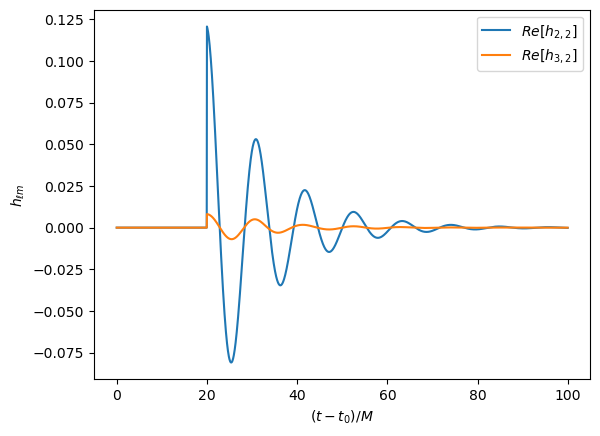

In [15]:
# Spherical (3,2) mode contains contributions from (3,2,0,1) QNM and mixing from (2,2,0,1) QNM
plt.plot(t, h[(2,2)].real, label='$Re[h_{2,2}]$')
plt.plot(t, h[(3,2)].real, label='$Re[h_{3,2}]$')
plt.xlabel('$(t-t_0)/M$')
plt.ylabel('$h_{\\ell m}$')
plt.legend()
plt.show()

## Reproduce Figure 10 from the paper (requires `sxs` package)

Here we reproduce the paper's figure 10.

In [16]:
import sxs

In [17]:
try:
    # When running the notebook interactively
    h_1450 = sxs.rpdmb.load('rhOverM_SXS:BBH:1450_BondiCce_R0260_superrest.h5')
except:
    # When pytest uses nbconvert to run the notebook, from one directory up
    h_1450 = sxs.rpdmb.load('examples/rhOverM_SXS:BBH:1450_BondiCce_R0260_superrest.h5')

In [18]:
import quaternionic

t_rot = 20.
i_rot = np.argmin(np.abs(h_1450.t - t_rot))

phi = np.angle(h_1450.data[i_rot, h_1450.index(2,2)]) / 2

quat = quaternionic.array.from_axis_angle([0, 0, -phi])

h_1450_rot = h_1450.rotate(quat)

In [19]:
q_1450     = 0.802685097447/0.197348567421
chi_A_1450 = [0, 0, -0.283524531349]
chi_B_1450 = [0, 0, -0.799219201717]
h_RD = sur_h_ringdown(q_1450, chi_A_1450, chi_B_1450, h_1450_rot.t)

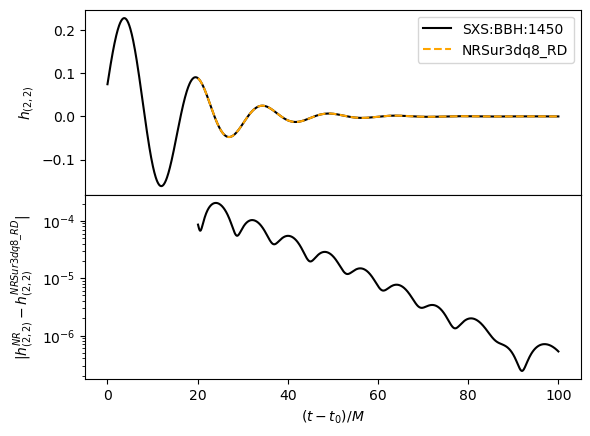

In [20]:
plot_mode = (2,2)

i_QNM = 1+np.argmin(np.abs(h_1450_rot.t - 20.))

fig, ax = plt.subplots(nrows=2, sharex=True)

ax[0].plot(h_1450_rot.t, h_1450_rot[:, h_1450_rot.index(*plot_mode)].real, 'k', label='SXS:BBH:1450')
ax[0].plot(h_1450_rot.t[i_QNM:], h_RD[plot_mode][i_QNM:].real, '--', color='orange', label='NRSur3dq8_RD')
ax[0].set_ylabel(f'$h_{{{plot_mode}}}$')
ax[0].legend()

ax[1].plot(h_1450_rot.t[i_QNM:],
           np.abs(h_1450_rot[:, h_1450_rot.index(*plot_mode)] - h_RD[plot_mode])[i_QNM:].real, 'k')
ax[1].set_yscale('log')
ax[1].set_xlabel('$(t-t_0)/M$')
ax[1].set_ylabel(f'$|h^{{NR}}_{{{plot_mode}}} - h^{{NRSur3dq8\\_RD}}_{{{plot_mode}}}|$')

plt.subplots_adjust(hspace = 0, wspace = 0)

plt.show()

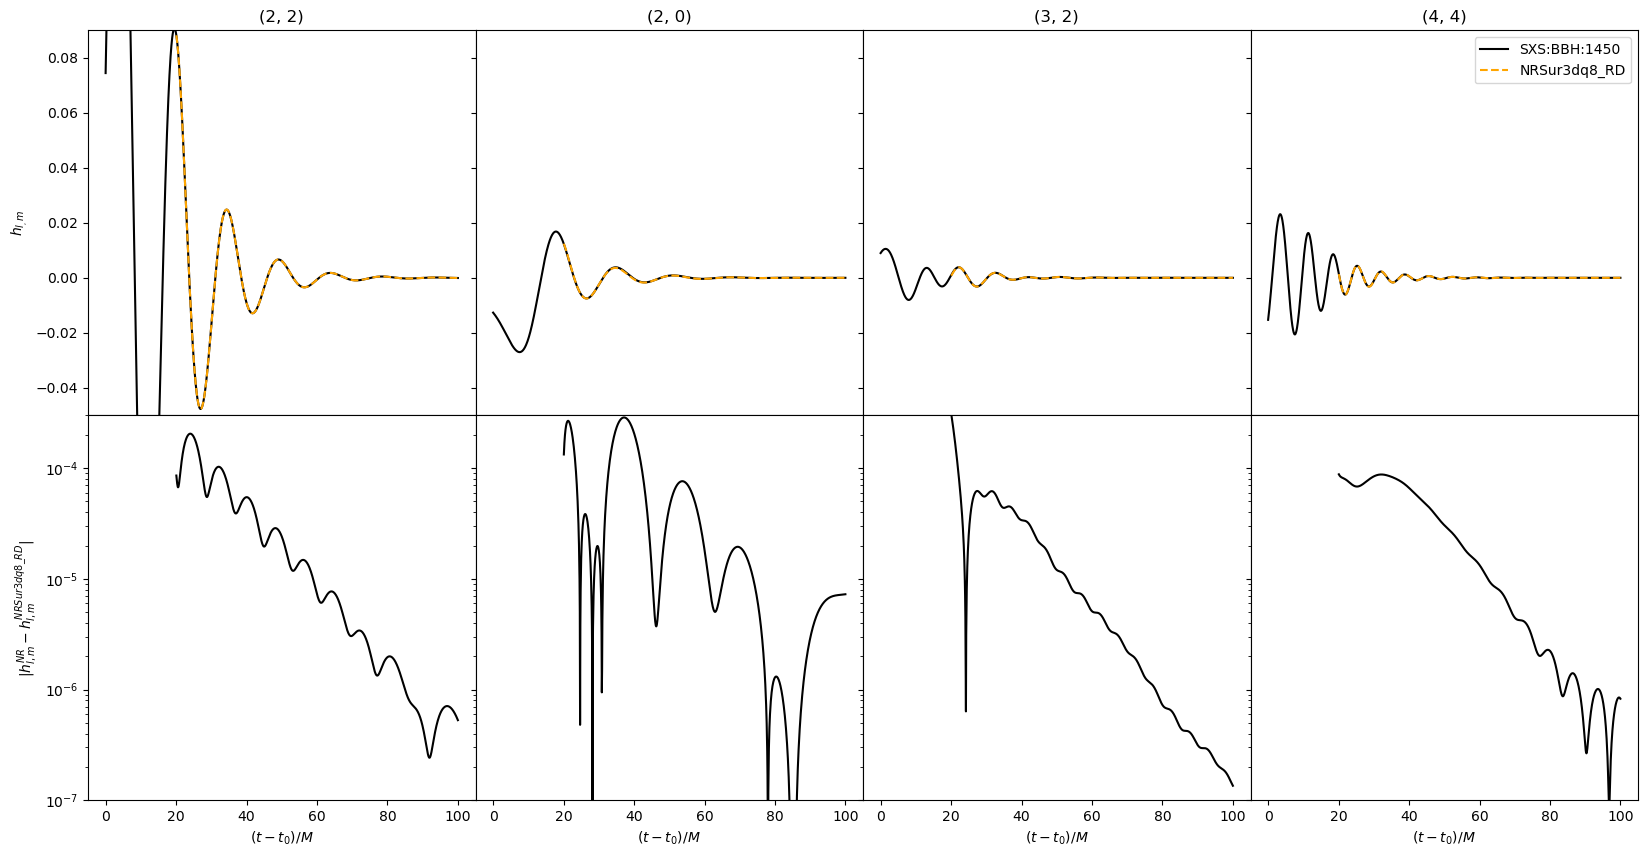

In [21]:
mode_cols = [(2,2),(2,0),(3,2),(4,4)]

i_QNM = 1+np.argmin(np.abs(h_1450_rot.t - 20.))

fig, ax = plt.subplots(nrows=2, ncols=len(mode_cols),
                       figsize=(20,10),
                       sharex=True, sharey='row')
plt.subplots_adjust(hspace = 0, wspace = 0)

for i, plot_mode in enumerate(mode_cols):

    ax[0, i].plot(h_1450_rot.t, h_1450_rot[:, h_1450_rot.index(*plot_mode)].real, 'k', label='SXS:BBH:1450')
    ax[0, i].plot(h_1450_rot.t[i_QNM:], h_RD[plot_mode][i_QNM:].real, '--', color='orange', label='NRSur3dq8_RD')
    if i==0:
        ax[0, i].set_ylabel(f'$h_{{l_,m}}$')
    if i==len(mode_cols)-1:
        ax[0, i].legend()

    ax[0,i].set_title(f'{plot_mode}')
    ax[0,i].set_ylim([-.05, .09])
    
    ax[1, i].plot(h_1450_rot.t[i_QNM:],
               np.abs(h_1450_rot[:, h_1450_rot.index(*plot_mode)] - h_RD[plot_mode])[i_QNM:].real, 'k')
    ax[1, i].set_yscale('log')
    ax[1, i].set_xlabel('$(t-t_0)/M$')
    if i==0:
        ax[1, i].set_ylabel(f'$|h^{{NR}}_{{l,m}} - h^{{NRSur3dq8\\_RD}}_{{l,m}}|$')

    ax[1,i].set_ylim([1.e-7, 3.e-4])

plt.show()